# Tree decomposition, treewidth, and other stories

In [2]:
import networkx as nx

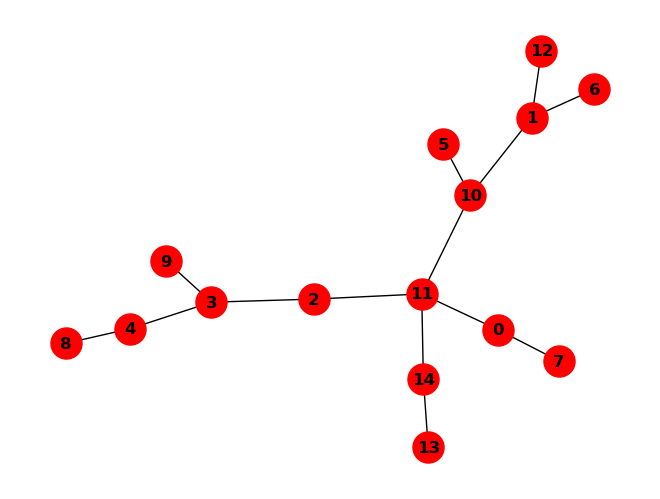

In [16]:
Tree = nx.generators.random_tree(15, seed = 42)
nx.draw(Tree, with_labels = True, font_weight='bold', node_size = 500, node_color = 'red')

# Maximum Independent Set on Trees
Maximum independent set is a classical NP-Complete problem.
NP-Complete problems are usually difficult to solve and require extensive computation. On trees, many NP-Complete problems can be solved efficiently and in an exact way in linear time, using dynamic programming.

> **Definition (Independent set)**: Let $G = (V, E)$, an independent set $IS(G)$ is a set of nodes $C \subset V$ such that no edges exist between these nodes.
>
> Formally: $$ IS(G) = \left\{ C \subset V:\quad \forall u, v \in C\; \nexists (u,v) \in E\right\}$$
 
Let's implement a function to compute the maximum independent set on a tree using dynamic programming. We define two tables $M^+[v]$, where we store the size of the largest independent set in $v$'s subtree, including the node $v$ and $M^-[v]$, where we store the size of the largest independent set in $v$'s subtree excluding the node v. With this wto tables we can solve the MIS on a tree in linear time as follows. we root the tree on a random node and we visit the nodes of the tree in postorder (dfs). For each node with children $w_1, \dots ,w_d$ we compute the following:

$$ 
 M^+[v] = 1 + \sum_{i=0}^{i=d} M^-[w_i]\\
 M^-[v] = \sum_{i=0}^{i=d} \max{\left(M^+[w_i], M^-[w_i]\right)}
$$

NetworkX offers two useful functions here: 
- bfs\_successors: which takes a tree and a root node and returns the successors of each node
- dfs\_postorder\_nodes: which, given a tree and a root node, returns the the nodes of the tree in postorder

We compute the MIS on the tree we plotted above.

In [56]:
def MIS_on_tree(tree):
    # Your code here
    pass

In [ ]:
MIS_on_tree(Tree)

# Tree Decomposition of Graphs

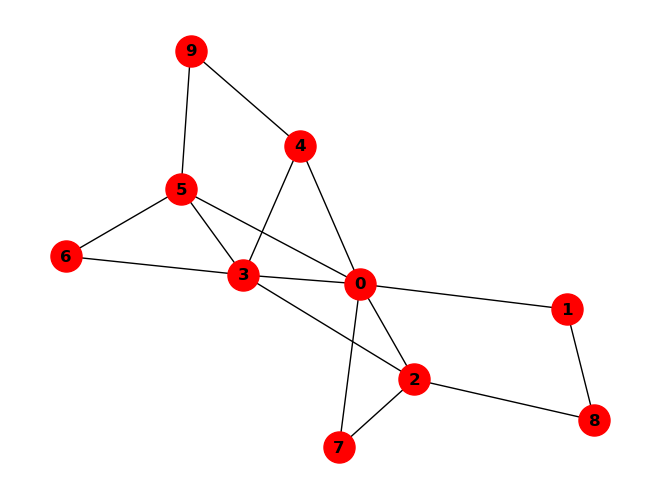

In [36]:
G = nx.Graph(
    [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (1, 8), (2, 3),
     (2, 7), (2, 8), (3, 4), (3, 5), (3, 6), (4, 9), (5, 6), (5, 9)]
)
pos = pos = nx.spring_layout(G)
nx.draw(G, pos=pos, with_labels = True, font_weight='bold', node_size = 500, node_color = 'red')

Let's compute the tree decomposition with the minimum degree heuristic

In [37]:
w, T = nx.approximation.treewidth_min_degree(G) # Yes! NetworkX offers an implementation of the algorithm you have seen today!
print("The graph G has treewidth at most %d; as such, %d cops are sufficient to catch a robber in this graph." %(w, w+1))

The graph G has treewidth at most 3; as such, 4 cops are sufficient to catch a robber in this graph.


Let's plot the tree decomposition

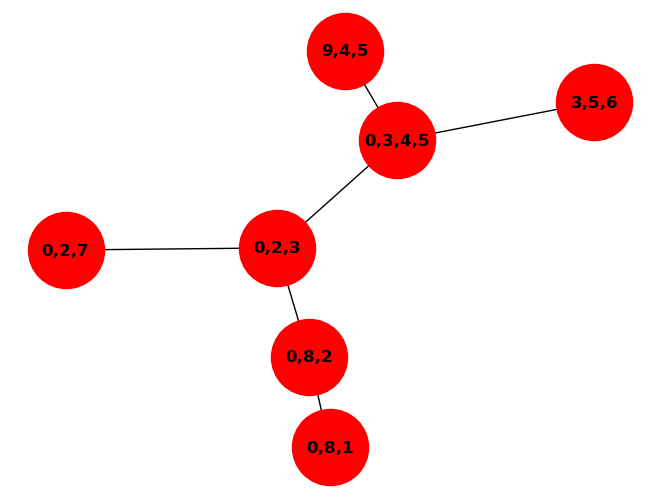

In [38]:
labels = {node:','.join(list(map(str, node))) for node in T}
nx.draw(T, labels=labels, font_weight='bold', node_color = 'red', node_size = 3000)

Let's implement a function to perform a tree decomposition of a graph. We assume first that the elimination order is given. Later on we will focus on the minimum degree heuristic.
Given an elimination order, we need to remove each node from a graph, make a bag with the node we have just removed and its neighbours, and triangulate the neighbours in the graph (that is, we connect all the neighbours of the node we have removed with each other).
If the bag is already a subset of an existing bag, we discard it.
When we have removed all the nodes, we connect each bag with the bag for which the intersection of the nodes contained in the bags is the maximum.

In [58]:
def tree_decomposition(G, elimination_order):
    # your code here!
    pass

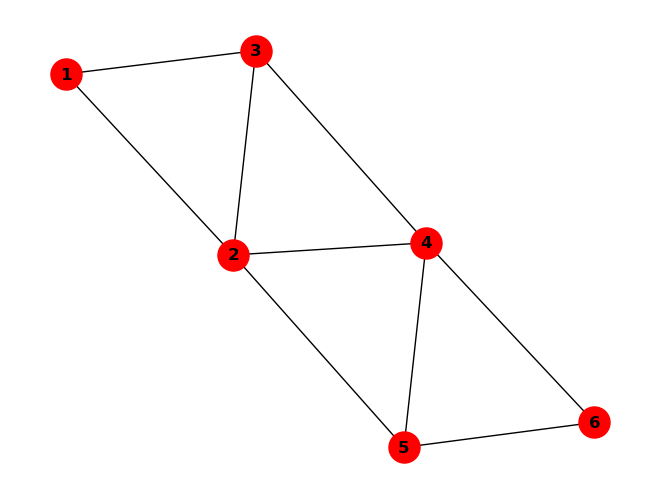

In [40]:
G2 = nx.Graph(
    [(1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (2, 5), (4, 5), (5, 6), (4, 6)]
)
pos = pos = nx.spring_layout(G2)
nx.draw(G2, pos=pos, with_labels = True, font_weight='bold', node_size = 500, node_color = 'red')

Consider this graph and obtain a tree decomposition

In [41]:
# It should print "The graph G has treewidth at most 3; as such, 4 cops are sufficient to catch a robber in this graph."
w, T = tree_decomposition(G2, [1,2,3,4,5,6])
print("The graph G has treewidth at most %d; as such, %d cops are sufficient to catch a robber in this graph." %(w, w+1))

The graph G has treewidth at most 3; as such, 4 cops are sufficient to catch a robber in this graph.


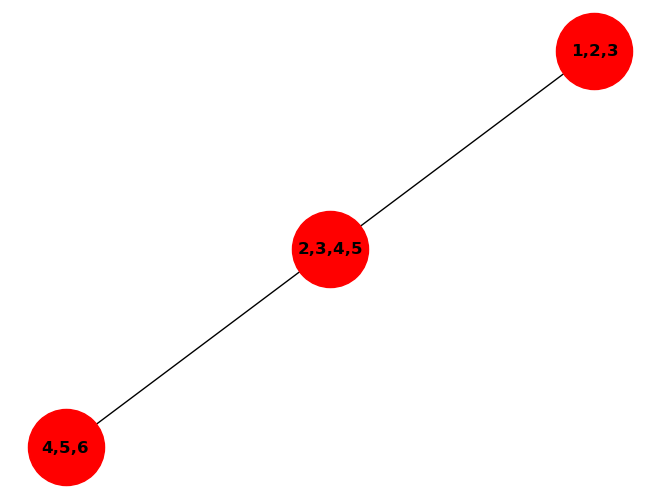

In [42]:
# It should plot a line tree with three bags, two of which contain 3 nodes and one contains 4 nodes.
labels = {node:','.join(list(map(str, node))) for node in T}
nx.draw(T, labels=labels, font_weight='bold', node_color = 'red', node_size = 3000)

Let's consider a different node removal order

In [43]:
# It should print "The graph G has treewidth at most 2; as such, 3 cops are sufficient to catch a robber in this graph."
w, T = tree_decomposition(G2, [1,3,2,4,5,6])
print("The graph G has treewidth at most %d; as such, %d cops are sufficient to catch a robber in this graph." %(w, w+1))

The graph G has treewidth at most 2; as such, 3 cops are sufficient to catch a robber in this graph.


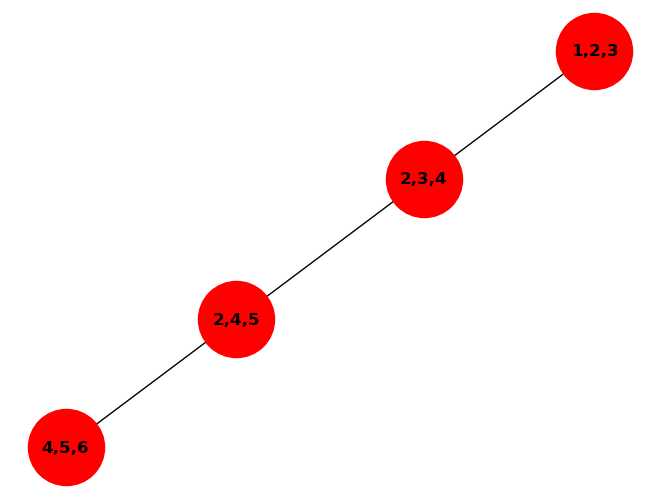

In [44]:
# It should plot a line tree with four bags, each containing 3 nodes
labels = {node:','.join(list(map(str, node))) for node in T}
nx.draw(T, labels=labels, font_weight='bold', node_color = 'red', node_size = 3000)

This shows that the elimination order matters. So, now, let's implement the minimum degree heuristic to obtain a good elimination order.

In [59]:
def min_degree_elimination_order(G):
    # Your code here
    pass

Let's consider again the first graph G. Let's now compute the tree decomposition with the minimum degree heuristic.

In [53]:
w, T = tree_decomposition(G,
 min_degree_elimination_order(G))
print("The graph G has treewidth at most %d; as such, %d cops are sufficient to catch a robber in this graph." %(w, w+1))

The graph G has treewidth at most 3; as such, 4 cops are sufficient to catch a robber in this graph.


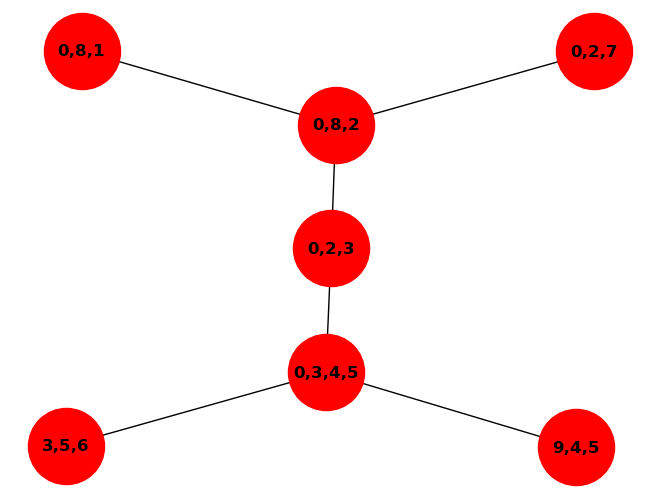

In [55]:
# This should plot a tree decomposition equivalent to the one obtained by the NetworkX function
labels = {node:','.join(list(map(str, node))) for node in T}
nx.draw(T, labels=labels, font_weight='bold', node_color = 'red', node_size = 3000)